# Домашнее задание #3: Ансамбли моделей

В этом домашнем задании вам предлагается написать свою реализацию алгоритма градиентного бустинга и применить его для задачи регрессии.

In [1]:
import tqdm
import numpy as np
from scipy.special import expit as sigmoid
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Часть 1. Реализация градиентного бустинга

Нужно реализовать класс для модели градиентного бустинга на деревьях (3 балла) и вспомогательные классы для функций потерь MSE (1 балл) и BCE (1 балл).

За что можно получить дополнительные баллы:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

### 1. Функции потерь

Начнем с функций потерь. Нам нужны будут две функции потерь, одна для задачи классификации и одна для задачи регрессии. Для каждой из них напишем отдельный класс, который позволит вычислять как саму функцию потерь, так и ее градиент.

#### 1.1. Базовый класс Loss

Сначала напишем базовый класс `Loss`, от которого будем наследоваться при написании функций потерь.
Вычисление значения функции потерь будет производиться в методе `forward`, а градиента - в методе `backward`.

Метод `forward` должен получать на вход два вектора: вектор целевых переменных и вектор предсказаний модели.
Метод должен: 
* проверять, что длины векторов совпадают (с помощью `assert`)
* возвращать вектор той же длины, содержащий значения функции потерь для каждого из объектов

Метод `grad` должен делать то же самое, но возвращать значение градиента функции потерь.

In [2]:
class Loss(object):
    
    def __call__(self, y, p):
        """
        Call and use .forward()
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        return self.forward(y, p)
        
    def forward(self, y, p):
        """
        Calculate loss value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        raise NotImplementedError
        
    def grad(self, y, p):
        """
        Calculate grad value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like grad values
        """
        raise NotImplementedError

#### 1.2. Функция потерь для задачи регрессии (MSE)

Для задачи регрессии будем использовать `Mean Squared Error (MSE)`:

$$L = MSE(y,p) = \frac{1}{2n}(y - p) ^ 2$$

Ее градиент:
$$\frac{\partial L}{\partial p} = \frac{1}{n}(p - y)$$

В формулах выше `p` - предсказания модели.

In [3]:
class MSELoss(Loss):
    
    def forward(self, y, p):
        # Your code here
        assert (len(y) == len(p))
        loss = np.empty_like(y)
        for i in range(len(y)):
            loss[i] = (y[i] - p[i]) ** 2
    
        return  0.5 * loss / len(y)
    
    def grad(self, y, p):
        # Your code here
        assert (len(y) == len(p))
        return (p-y) / len(y)

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [4]:
mse_loss = MSELoss()

ys = np.array((10, 20, 30))
ps = np.array((5, 25, 30))

np.testing.assert_raises(AssertionError, mse_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, mse_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_almost_equal(mse_loss(ys, ps), np.asarray([4.16667, 4.1666, 0]), decimal=4)
np.testing.assert_almost_equal(mse_loss.grad(ys, ps), np.asarray([-1.66667, 1.66667, 0]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

#### 1.3. Функция потерь для задачи классификации (BCE)

Для задачи регрессии будем использовать `Binary Cross-Entropy (BCE)`:
$$L = BCE(y,p) = \frac{1}{n}(-y \log{p} - (1-y)\log{(1-p)})$$

Ее градиент по `p`:
$$\frac{\partial L}{\partial p} = \frac{(p - y)}{p(1-p)}$$

Вспомним, что для вычисления `p` используется сигмоида:
$$p = \sigma (z) = \frac{1}{1 + \exp (-z)}$$
$$\sigma (z)' = \sigma (z) (1 - \sigma (z))$$

Подставив последнее выражение в градиент функции потерь, получим аналогичное `MSE` выражение:
$$\frac{\partial L}{\partial z} = \frac{1}{n}(\sigma (z) - y)$$

В формулах выше `z` - предсказания модели до применения сигмоиды, `p` - после.

**Важно:** для дальнейшего удобства методы `forward` и `grad` в качестве предсказаний должны получать `z`, **активации** модели, то есть результат вычислений модели без взятия сигмоиды от них; сигмоидальное преобразования реализуется внутри этих методов (см.код).

**Важно:** не забудьте при вычислении логарифмов добавить отсечку значений аргумента значениями (`eps`, 1 - `eps`) в избежание ошибок арифметики.

In [5]:
class BCEWithLogitsLoss(Loss):
    
    eps = 1e-5

    def forward(self, y, z):
        eps = 1e-5
        # Your code here  
        p = sigmoid(z)

        assert (len(y) == len(p))
        
        loss = np.empty_like(p)
        for i in range(len(y)):
            y[i] = float(y[i])
            if p[i] < eps:
                p[i] = eps
            elif p[i] > (1 - eps):
                p[i] = 1 - eps                
            loss[i] = (-1.) * y[i] * np.log(p[i]) - (1.-y[i]) * np.log(1-p[i])

        return loss / len(y)
    
    def grad(self, y, z):
        p = sigmoid(z)
        
        assert (len(y) == len(p))
        return (p-y) / len(y)

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [6]:
bce_loss = BCEWithLogitsLoss()

ys = np.array((1, 0, 0))
zs = np.array((0.0, 100.0, 1.0))

np.testing.assert_raises(AssertionError, bce_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, bce_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_array_less(bce_loss(ys, zs), np.inf)

np.testing.assert_almost_equal(bce_loss(ys, zs), np.asarray([0.231 , 3.8376, 0.4378]), decimal=4)
np.testing.assert_almost_equal(bce_loss.grad(ys, zs), np.asarray([-0.1667,  0.3333,  0.2437]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

### 2. Градиентный бустинг

#### 2.1. Класс GradentBoosting
После того, как были получены классы для функций потерь, можно приступать к реализации класса для градиентного бустинга `GradientBoosting`.
В качестве базовых моделей будем использовать деревья решений (`DecisionTreeRegressor` из `sklearn.tree`).
Итоговый вид композиции:
$$a(x) = \sum_{t=1}^{T}\eta * b_{t}(x)$$

Параметры класса (аргументы метода `__init__()`):
* `loss`: объект одного из двух классов, реализованных выше (`MSELoss` или `BCELoss`), будет определять поведение при вызове метода `predict()`.
* `n_estimators`: число деревьев `T` (итераций бустинга)
* `learning_rate`: темп обучения (коэффициент $\eta$)
* `max_depth`: максимальная глубина построенных деревьев (параметр `DecisionTreeRegressor`)
* `max_features`: число признаков для поиска наилучшего разбиения в узле (параметр `DecisionTreeRegressor`)

В методе `__init__()` создаются списки для хранения отдельных деревьев (`self.estimators`) и значений функции потерь на каждом шаге (`self.loss_values`).
Также имеется дополнительное поле `self.loss_values_evalset`, в котором можно хранить значения функции потерь на отложенной (`evalset`) выборке по итерациям.

Метод `fit(X, y, X_eval=None, y_eval=None)` должен:
* Инициализировать "нулевое приближение" средним значением целевой переменной, считать значение потерь при нем
* Итерируясь по числу деревьев:
  * Вычислять **антиградиент** функции потерь построенной композиции по каждому объекту (остатки), создавать новое дерево, обучать его на полученных остатках и добавлять в список деревьев.
  * Вычислять новое значение предсказания композиции для обучающей выборки (добавлением ответов нового дерева с весом $\eta$)
  * Считать новое значение функции потерь (суммарно по всем объектам) и добавлять в список
* В случае, если методу передаются также `X_eval` и `y_eval`, нужно вычислять значение функции потерь на этом множестве на каждой итерации.
  
Метод `predict(X)` должен:
* Для каждого объекта из `X` делать предсказание с помощью всех деревьев композиции  (**не забывайте про "нулевое приближение"**) и суммировать их
* Если решается задача классификации, применять сигмоиду на полученных ответах

In [7]:
class null_tree():
    @classmethod
    def predict(cls, X, y_mean):
        r = np.full((len(X),) , y_mean)
#         print(r)
        return r
    

In [8]:
def get_lab(pr):
    pr_lab = np.empty(len(pr),)
    for i in range(len(pr)):
        if pr[i] > 0.5:
            pr_lab[i] = 1.
        else:
            pr_lab[i] = 0.
    return pr_lab
        

In [9]:
from sklearn.metrics import accuracy_score, r2_score, f1_score, roc_auc_score, average_precision_score

In [10]:
class GradientBoosting(BaseEstimator):
    
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features='auto',
                 random_state=2):
        self.loss = loss
        
        # храним доп метрику: f1-score для классификации, r2-score - регрессии
        self.extra_metric_values = []
        self.extra_metric_values_evalset = []
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        
        self.max_depth = max_depth
        self.max_features = max_features
        
        self.estimators = []
        
        self.loss_values = []
        self.loss_values_evalset = []
        
        self.random_state = random_state
        
    
    def fit(self, X, y, X_evalset=None, y_evalset=None, verbose=False, early_stopping=False):
        # Your code here
        
       # initial tree
        self.y = y
        y_mean = np.mean(self.y)
        self.y_mean = y_mean
       
        if isinstance(self.loss, MSELoss):
            pred =  self.learning_rate * null_tree.predict(X,self.y_mean) 
            # доп метрика
            self.extra_metric_values.append(r2_score(self.y, pred))       
                                
        else: 
            pred = self.learning_rate * null_tree.predict(X,self.y_mean)
            pred = sigmoid(pred)
            # доп метрика
            self.extra_metric_values.append(f1_score(self.y, get_lab(pred)))
                       
        self.loss_values.append(self.loss(y, pred).sum())     
        
        
        # предсказание для eval_set с помощью начального приближения
        if np.all(X_evalset != None):
                self.y_evalset = y_evalset          
                pred_ev = self.predict(X_evalset)
                losses_eval = self.loss(y_evalset, pred_ev).sum()
                self.loss_values_evalset.append(losses_eval)
                
                if isinstance(self.loss, MSELoss):
                    self.extra_metric_values_evalset.append(r2_score(self.y_evalset, pred_ev))
                else: 
                    self.extra_metric_values_evalset.append(roc_auc_score(self.y_evalset, get_lab(pred_ev)))
                
        
        
        # итерируемся по числу деревьев
   
        for t in range(self.n_estimators):
            # Your code here

            g = - self.loss.grad(y, pred)
            
            # обучаем новое дерево на остатках
            tree = DecisionTreeRegressor(max_features=self.max_features, max_depth=self.max_depth)
            tree.fit(X, g)
            self.estimators.append(tree)
            
            # новое значение предсказания композиции для обучающей выборки
            pred = self.predict(X)
            
            # новое значение ф-ии потерь
            losses_new = self.loss(y, pred).sum()
            self.loss_values.append(losses_new)
            
            if verbose:
                print('estimator {}/{} , loss: {}\n'.format(t, self.n_estimators, losses_new))
            
            # новое значение доп метрики качества *
            if isinstance(self.loss, MSELoss):
                self.extra_metric_values.append(r2_score(self.y, pred))
            else: 
                self.extra_metric_values.append(f1_score(self.y, get_lab(pred)))
                
           
            # для eval_set
            if np.all(X_evalset != None):
                self.y_evalset = y_evalset          
                pred_ev = self.predict(X_evalset)
                losses_eval = self.loss(y_evalset, pred_ev).sum()
                self.loss_values_evalset.append(losses_eval)
                
                if isinstance(self.loss, MSELoss):
                    self.extra_metric_values_evalset.append(r2_score(self.y_evalset, pred_ev))
                else: 
                    self.extra_metric_values_evalset.append(roc_auc_score(self.y_evalset, get_lab(pred_ev)))
                
                # ранняя остановка
                if early_stopping and t>2 and (self.loss_values_evalset[-1] > self.loss_values_evalset[-2]):
                    break                   
            
    
    def predict(self, X):
        # Your code here
        estimators = self.estimators 
        pred = self.learning_rate * null_tree.predict(X, self.y_mean)
        
        if isinstance(self.loss, MSELoss):
       
            for ob in estimators:
                pred += self.learning_rate * ob.predict(X)
        else: 
                        
            for ob in estimators:
                pred += self.learning_rate * ob.predict(X)               
            pred = sigmoid(pred)
        return pred

#### 2.2. Тестирование класса GradientBoosting

##### 2.2.1. Интерфейс
*Код в ячейках ниже должен выполняться без ошибок.*

In [11]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

In [12]:
assert len(gb_test.estimators) == gb_test.n_estimators
assert gb_test.predict(X_test).shape == y_test.shape

Сгенерируем случайную выборку и убедимся, что функция потерь уменьшается при увеличении итераций.

*Код в ячейках ниже должен выполняться без ошибок.*

##### 2.2.2. Регрессия

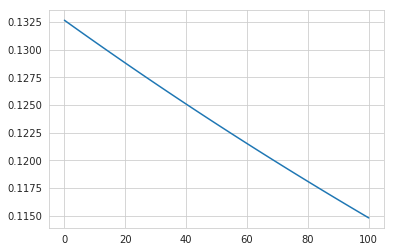

In [13]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

##### 2.2.3. Классификация

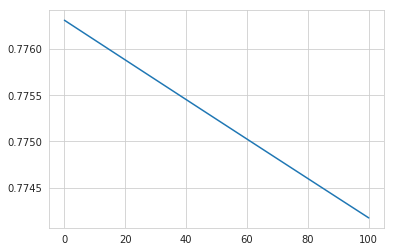

In [14]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.binomial(1, 0.5, size=100)

gb_test = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

### 3. Использование класса GradientBoosting

Проверим, как работает наш бустинг на двух задачах - регрессии и классификации на 2 класса.
Для этого будем использовать игрушечные выборки, полученные с помощью `sklearn.datasets.make_regression` и `sklearn.datasets.make_classificaiton`.

In [15]:
from sklearn.metrics import accuracy_score, mean_squared_error

#### 3.1. Задача регрессии

In [16]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [17]:
gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val, verbose=False)

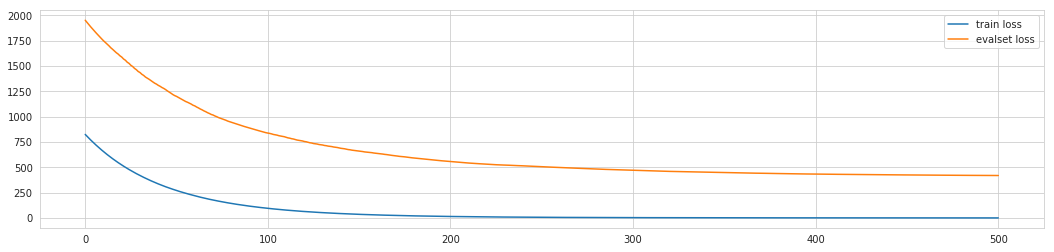

In [18]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.loss_values, label='train loss')
plt.plot(gb_regressor.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "среднее по датасету" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций они должны отличаться как минимум в 100 раз.

*Код в ячейках ниже должен выполняться без ошибок.*

In [19]:
# Train
y_mean = np.mean(y_train) * np.ones_like(y_train)
mse_baseline = mean_squared_error(y_train, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_train)
mse_boosting = mean_squared_error(y_train, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 1648.606
MSE для предсказаний бустинга: 1.946


In [20]:
# Val
y_mean = np.mean(y_val) * np.ones_like(y_val)
mse_baseline = mean_squared_error(y_val, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_val)
mse_boosting = mean_squared_error(y_val, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 3)

MSE для предсказания среднего по выборке: 3531.394
MSE для предсказаний бустинга: 837.892


#### 3.2. Задача классификации

In [21]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [22]:
gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_classifier.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val)

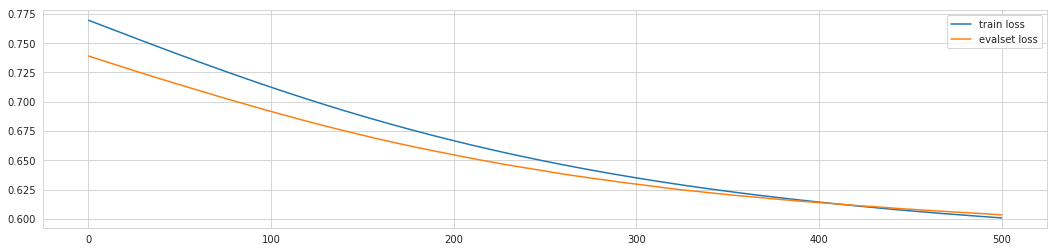

In [23]:
plt.figure(figsize=(18, 4))
plt.plot(gb_classifier.loss_values, label='train loss')
plt.plot(gb_classifier.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "подбрасывание монетки" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций ошибка бустинга должна быть как минимум вдвое меньше.

*Код в ячейках ниже должен выполняться без ошибок.*

In [24]:
# Train
y_random = np.random.binomial(1, 0.5, size=len(y_train))
accuracy_baseline = accuracy_score(y_train, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_train) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_train, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.487
Accuracy для предсказаний бустинга: 0.887


In [25]:
# Val
y_random = np.random.binomial(1, 0.5, size=len(y_val))
accuracy_baseline = accuracy_score(y_val, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_val) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_val, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.400
Accuracy для предсказаний бустинга: 0.800


Если все тесты пройдены успешно, попробуйте реализовать дополнительный функционал для вашего класса:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

Для того, чтобы дополнительные баллы были засчитаны, необходимо реализовать функционал и продемонстрировать результат в ячейке внизу.

### Ранняя остановка обучения


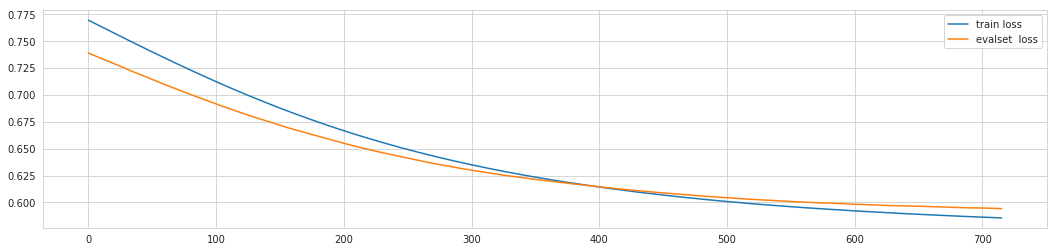

In [26]:
gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=1000, learning_rate=1.0, max_depth=3)
gb_classifier.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val, early_stopping=True)

plt.figure(figsize=(18, 4))
plt.plot(gb_classifier.loss_values, label='train loss')
plt.plot(gb_classifier.loss_values_evalset, label='evalset  loss')
plt.legend()
plt.show()

In [27]:
# Смотрим на полученное количество деревьем - меньше, чем n_estimators,
# произошла ранняя остановка обучения

assert len(gb_classifier.estimators) < gb_classifier.n_estimators

print(len(gb_classifier.estimators), gb_classifier.n_estimators)

715 1000


### Введем доп метрики качества, для регрессии r2-score, для классификации roc-auc

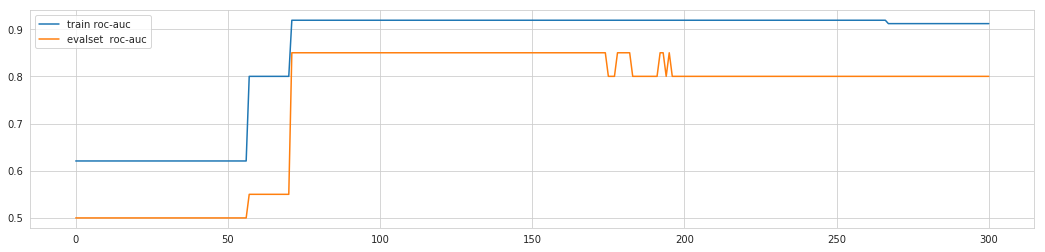

In [28]:
# Классификация
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                           n_repeated=0, n_clusters_per_class=1, flip_y=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=300, learning_rate=1.0, max_depth=4)
gb_classifier.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val)

plt.figure(figsize=(18, 4))
plt.plot(gb_classifier.extra_metric_values, label='train roc-auc')
plt.plot(gb_classifier.extra_metric_values_evalset, label='evalset  roc-auc')
plt.legend()
plt.show()


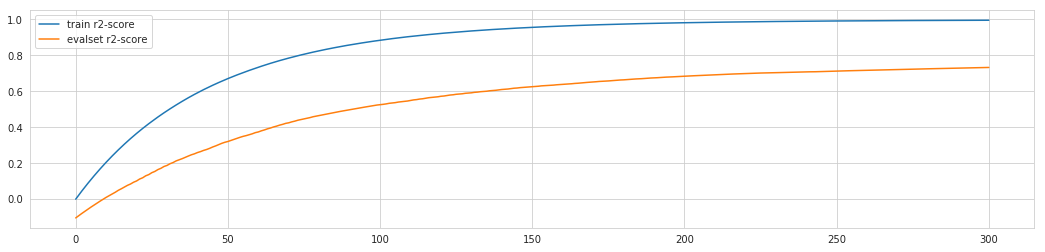

In [29]:
# Регрессия

X, y = make_regression(n_samples=100, n_features=2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=300, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val)

plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.extra_metric_values, label='train r2-score')
plt.plot(gb_regressor.extra_metric_values_evalset, label='evalset r2-score')
plt.legend()
plt.show()

## Часть 2. Решение задачи предсказания цены футболиста в FIFA 18 Ultimate Team

Нужно обучить какой-либо из рассмотренных в курсе ансамблей предсказывать трансферную стоимость футболиста из FIFA 18 Ultimate Team. Решение будет оцениваться по метрике MSE на тестовой выборке. Засчитывается только решение, качество которого на тестовой выборке окажется выше, чем у бейзлайна (см. в конце ноутбука).

Данные для обучения - `train_with_targets.csv`, столбец с целевой переменной - `price_ps4`.
Для отправки решения заполните столбец `price_ps4` в файле `test_submission.csv` предсказаниями своей модели на признаках из файла `test.csv` (убедитесь, что порядок следования `player_id` верный).

Для обучения моделей следует использовать:
* \*Свой класс для градиентного бустинга, реализованный выше
* Любые ансамбли из `sklearn` (`RandomForestRegressor`, `GradientBoostingRegressor`, ...)
* Любые фреймворки для градиентного бустинга (`XGBoost`, `LightGBM`, `CatBoost`, ...)
* \*Стекинг/блендинг (свой или тот, что был реализован на лекциях)
* Подбор гиперпараметров с помощью `RandomizedSearch` / `hyperopt` / ... 

Использование пунктов со звездочкой может накинуть дополнительных баллов за задание (по 1 баллу за пункт, т.е. максимум 2 дополнительных балла).

Удачи!

*Ниже приведен пример бейзлайна на случайном лесе из `sklearn`.*

### Baseline на RandomForestClassifier из Sklearn.ensemble

In [193]:
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
data_train = pd.read_csv('./data/train_with_targets.csv')
data_train.head()

,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,nationality,...,cam,cf,rf,lf,rw,lw,st,price_ps4,traits,specialties
0,20920,Sacko,Hadi Sacko,Silver - Rare,Normal,Transfers,68,UD Las Palmas,LaLiga Santander,France,...,65.0,67.0,67.0,67.0,68.0,68.0,66.0,1000.0,"Tries To Beat Defensive Line, Selfish, Dribble...",Speedster
1,2996,Koo Ja Ryong,Ja Ryong Koo,Silver - Rare,Normal,NaN,73,Suwon Samsung Bluewings,K LEAGUE Classic,Korea Republic,...,48.0,46.0,46.0,46.0,46.0,46.0,46.0,450.0,Leadership,NaN
2,12998,Gipson,Ken Gipson,Bronze,Normal,NaN,60,SV Sandhausen,Bundesliga 2,Germany,...,49.0,49.0,49.0,49.0,51.0,51.0,49.0,200.0,NaN,NaN
3,16112,Yoda,Abdoul Karim Yoda,Silver,Normal,Transfers,69,CF Reus,LaLiga 1 I 2 I 3,France,...,66.0,67.0,67.0,67.0,69.0,69.0,65.0,350.0,"Flair, Technical Dribbler",NaN
4,16502,Ronan,Connor Ronan,Bronze - Rare,Normal,Transfers,64,Portsmouth,EFL League One,Republic of Ireland,...,63.0,61.0,61.0,61.0,63.0,63.0,56.0,200.0,NaN,NaN


In [194]:
data_train_num = data_train.select_dtypes(include=['int', 'float'])
data_train_num.fillna(data_train_num.mean(), inplace=True)
data_train_num.head()

/home/olya/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,player_ID,overall,age,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,...,rm,lm,cam,cf,rf,lf,rw,lw,st,price_ps4
0,20920,68,24,183,79,1,91.0,90.0,91.0,69.0,...,67.0,67.0,65.0,67.0,67.0,67.0,68.0,68.0,66.0,1000.0
1,2996,73,26,183,75,1,72.0,69.0,74.0,49.0,...,48.0,48.0,48.0,46.0,46.0,46.0,46.0,46.0,46.0,450.0
2,12998,60,22,178,69,1,76.0,75.0,76.0,55.0,...,52.0,52.0,49.0,49.0,49.0,49.0,51.0,51.0,49.0,200.0
3,16112,69,29,182,73,1,84.0,79.0,88.0,73.0,...,68.0,68.0,66.0,67.0,67.0,67.0,69.0,69.0,65.0,350.0
4,16502,64,20,170,63,1,81.0,80.0,82.0,68.0,...,63.0,63.0,63.0,61.0,61.0,61.0,63.0,63.0,56.0,200.0


In [195]:
from sklearn.model_selection import train_test_split as tts

X = data_train_num.drop(labels=['price_ps4'], axis=1).values[:, 1:]
y = data_train_num['price_ps4'].values
print(X.shape, y.shape)

X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, random_state=2)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18629, 64) (18629,)
(14903, 64) (14903,)
(3726, 64) (3726,)


In [196]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1, n_jobs=-1)
rf_regressor.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [197]:
rf_regressor_pred = rf_regressor.predict(X_train)
print('train MSE:', mean_squared_error(rf_regressor_pred, y_train))
rf_regressor_pred = rf_regressor.predict(X_val)
print('val MSE:', mean_squared_error(rf_regressor_pred, y_val))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


train MSE: 348540141.05857
val MSE: 3314125090.866273


In [198]:
# Your code here
rf_regressor_pred_train = mean_squared_error(rf_regressor.predict(X_train), y_train)
rf_regressor_pred_val = mean_squared_error(rf_regressor.predict(X_val), y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [199]:
data_test = pd.read_csv('./data/test_with_targets.csv')
data_test_num = data_test.select_dtypes(include=['int', 'float'])
data_test_num.fillna(data_test_num.mean(), inplace=True)

X_test_all = data_test_num.values[:, 1:-1]
# print(X_test_all.shape)
rf_regressor_pred_test = mean_squared_error(rf_regressor.predict(X_test_all), y_test)
print(rf_regressor_pred_test)

/home/olya/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1341233491.2639506


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


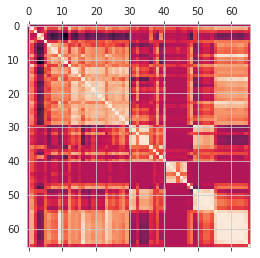

In [200]:
# смотрим есть ли коррелирующие признаки
plt.matshow(data_train_num.corr())


In [201]:
# будем удалять признаки с корреляцией > 0.8
M = data_train_num.corr()
as_matrix = np.array(M)

arr_pr =[]
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if as_matrix[i,j] > 0.8 and i != j:
#             print (data_train_num.columns.values[i], data_train_num.columns.values[j])
            arr_pr.append((data_train_num.columns.values[i], data_train_num.columns.values[j]))


In [202]:
# составим список имен столбцов, которые коррелируют с другими 

first_to_drop = []
for i in range(len(arr_pr)):
    if arr_pr[i][0] in first_to_drop:
        if arr_pr[i][1] in first_to_drop:
            pass
        else:
            first_to_drop.append(arr_pr[i][1])
    else:
        if arr_pr[i][1] in first_to_drop:
            pass
        else:
            first_to_drop.append(arr_pr[i][0])      
print(first_to_drop)

['overall', 'pace_acceleration', 'drib_agility', 'dribbling', 'passing', 'cm', 'rm', 'lm', 'cam', 'cf', 'rf', 'lf', 'rw', 'lw', 'st', 'drib_ball_control', 'shoot_positioning', 'shoot_finishing', 'shoot_shot_power', 'shoot_long_shots', 'shoot_volleys', 'pass_crossing', 'pass_short', 'pass_curve', 'drib_dribbling', 'shoot_penalties', 'pass_free_kick', 'pass_long', 'defending', 'def_marking', 'def_stand_tackle', 'def_slid_tackle', 'cb', 'rb', 'lb', 'cdm', 'def_interceptions', 'physicality', 'gk_diving', 'gk_handling', 'gk_positoning', 'gk_reflexes', 'rwb', 'lwb', 'shooting']


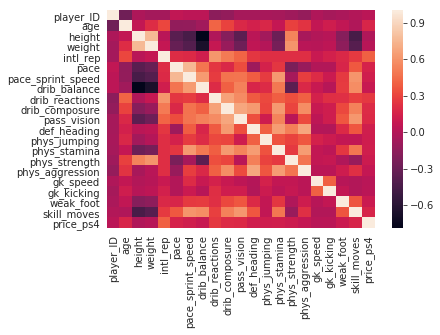

In [203]:
import copy
data_train_new = copy.copy(data_train_num)

for i in range(len(first_to_drop)):
    del data_train_new[first_to_drop[i]]
    
# смотрим еще раз на матрицу корреляций. 
import seaborn as sns
corr = data_train_new.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [204]:
# Данные для обучения
X_new = data_train_new.drop(labels=['price_ps4'], axis=1).values[:, 1:]
y = data_train_new['price_ps4'].values
print(X_new.shape, y.shape)

X_train, X_val, y_train, y_val = tts(X_new, y, test_size=0.2, random_state=2)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18629, 19) (18629,)
(14903, 19) (14903,)
(3726, 19) (3726,)


In [205]:
data_train_new.to_csv("data/train_feature.csv")

In [206]:
data_test = pd.read_csv('./data/test_with_targets.csv')
data_test.head()

,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,nationality,...,cam,cf,rf,lf,rw,lw,st,price_ps4,traits,specialties
0,9991,Pálsson,Victor Pálsson,Bronze - Rare,Normal,NaN,64,FC Zürich,Raiffeisen Super League,Iceland,...,60.0,59.0,59.0,59.0,58.0,58.0,60.0,200.0,Dives Into Tackles,NaN
1,13037,Palomeque,Ezequiel Palomeque,Bronze - Rare,Normal,NaN,60,Atlético Nacional,Liga Dimayor,Colombia,...,32.0,33.0,33.0,33.0,32.0,32.0,38.0,500.0,NaN,Strength
2,1254,Partey,Thomas Partey,Gold - Rare,Normal,NaN,77,Atlético Madrid,LaLiga Santander,Ghana,...,70.0,69.0,69.0,69.0,69.0,69.0,68.0,900.0,Dives Into Tackles,NaN
3,19697,Mirante,Antonio Mirante,Gold,Normal,Transfers,80,Roma,Calcio A,Italy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN
4,12390,Allen,Jordan Allen,Bronze,Normal,NaN,61,Real Salt Lake,Major League Soccer,United States,...,61.0,60.0,60.0,60.0,61.0,61.0,58.0,200.0,NaN,NaN


## XGBoost

In [207]:
import xgboost

In [208]:
def plot_metric(param_name, param_values, train_values, val_values, log_x=False):
    plt.figure(figsize=(16, 5))
    plt.plot(param_values, train_values, 'o-', label='train')
    plt.plot(param_values, val_values, 'o-', label='val')

    plt.xlabel(param_name)
    if log_x:
        plt.xscale('log')
    plt.ylabel('metric')
    plt.legend(loc='best')
    plt.title(param_name)
    plt.show()

In [209]:
# xgb = xgboost.XGBRegressor(n_estimators=2000, learning_rate=0.008, n_jobs=-1, max_depth=5)
xgb = xgboost.XGBRegressor(n_estimators=5000, learning_rate=0.05, n_jobs=4, max_depth=6)

In [210]:
%%time
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse', verbose=False, early_stopping_rounds=5)

CPU times: user 10 s, sys: 78.1 ms, total: 10.1 s
Wall time: 2.57 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

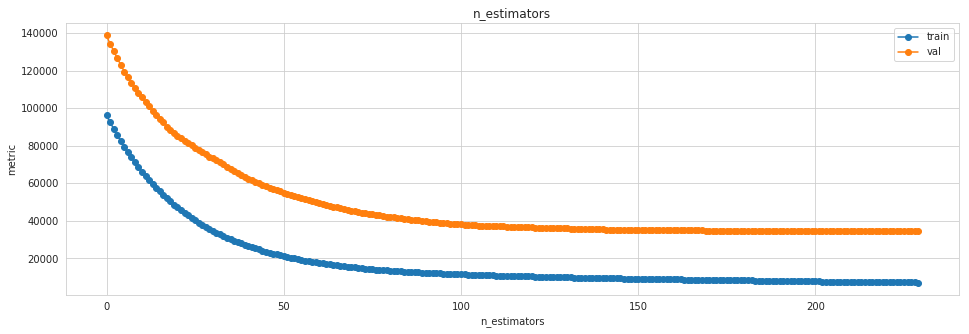

In [211]:
plot_metric(param_name='n_estimators', param_values=range(len(xgb.evals_result_['validation_0']['rmse'])), 
            train_values=xgb.evals_result_['validation_0']['rmse'], 
            val_values=xgb.evals_result_['validation_1']['rmse'])

In [212]:
xgb_mse_tr = mean_squared_error(xgb.predict(X_train), y_train)
xgb_mse_val = mean_squared_error(xgb.predict(X_val), y_val)

print(xgb_mse_tr / rf_regressor_pred_train)
print(xgb_mse_val / rf_regressor_pred_val)

0.15228336594367822
0.36097221180561945


## Predict on test

Predict on test set

In [213]:
data_test = pd.read_csv('./test_with_targets.csv')
data_test_num = data_test.select_dtypes(include=['int', 'float'])
# data_test_num.drop(labels=['price_ps4'], axis=1)
data_test_num.fillna(data_test_num.mean(), inplace=True)
for i in range(len(first_to_drop)):
    del data_test_num[first_to_drop[i]]
    
X_test = data_test_num.values[:, 1:-1]
y_test = data_test_num.values[:, -1:]

/home/olya/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [214]:
pred_test = xgb.predict(X_test)

In [215]:
mse_test = mean_squared_error(pred_test, y_test)
print(mse_test)

1187094635.492988


In [216]:
mse_test / rf_regressor_pred_test

0.8850767917928256

In [217]:
print(rf_regressor_pred_test)

1341233491.2639506


In [218]:
mse_test / rf_regressor_pred_test

0.8850767917928256